We will analyze more probability distributions this time using Stan and generated quantities block. Remember to set algorithm to "fixed params" (see notebooks). In order to find how to use distribution functions check Stan documentation, in particular Stan Language Functions Reference. All models used for sampling should take distribution parameters as data to avoid need for recompilation.

- Gamma family distributions. These distributions are defined for positive real numbers. Provide histograms of Gamma and invGamma distributions. See how tail behavior of those distributions behave. Using albebra_solver (see notebook from lecture on poisson distribution modelling) find parameters for Gamma and invGamma for which 98% probability is for values between 5 and 10. Sample for those distributions and compare histograms.

- Negative binomial distribution. Negative binomial distribution can be used in order to relax the constraints of equal mean and variance of Poissson distribution. Using both concentration and dispersion parametrization sample from negative binomial with fixed mean and see how it behaves in comparison to the Poisson with the same mean.

- Student-t family distributions. Student-t distributions can be considered generalizations of Gaussian distributions with varying scale. Use both degrees of freedom and dispersion parametrizations to see how changing parameters moves from normal distribution. Take a special case of degrees of freedom equal to 1, as this is Cauchy distribution. See how mean and variance behave while you increase number of samples.

- Multivariate normal distributions Consider density plots and 2d histograms for visualisation of behavior of 2 dimensional Multivariate normal. Use the correlation matrix decompositon of covariance matrix to see how individual variances and correlations infulence the distribution. For 3 and 4 dimensional normal distributions observe the marginals of variables with histograms.

In [1]:
# enviroment conda to start: DataAnalytics
# command: conda activate DataAnalytics

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import pystan
import stan_utility

import scipy.stats as stats
import matplotlib as mpl

In [2]:
# create const
size = 100000

shape1 = 2
scale1 = 1

shape2 = 4
scale2 = 1

shape3 = 2
scale3 = 2

shape4 = 4
scale4 = 2

In [3]:
# create data - gamma distribution - with different params
dict_with_gamma={
    f"shape={shape1}_scale={scale1}":np.random.gamma(shape1, scale1, size=size),
    f"shape={shape2}_scale={scale2}":np.random.gamma(shape2, scale2, size=size),
    f"shape={shape3}_scale={scale3}":np.random.gamma(shape3, scale3, size=size),
    f"shape={shape4}_scale={scale4}":np.random.gamma(shape4, scale4, size=size)
}

# change dict to pandas' DataFrame
df=pd.DataFrame.from_dict(dict_with_gamma)
df_melt = df.melt()

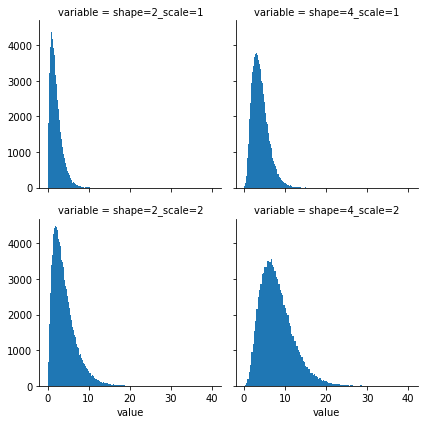

In [4]:
# plot the data, bins set to 128
graph1 = Graph=sns.FacetGrid(df_melt, col="variable", sharex=True, col_wrap=2).map(plt.hist, 'value', bins=128)

In [5]:
# some stuff from example, maybe will be used with plotting
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"


colors=[light,light_highlight,mid,mid_highlight,dark,dark_highlight,green,light_grey]

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


In [6]:
# location+name of the model:
model_name_prior = 'gamma_prior.stan'

# show the model
with open(model_name_prior, 'r') as model:
    print(model.read())

# compile model
model_gamma_prior=stan_utility.compile_model(model_name_prior)

//based on the example
functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    //values between 5 and 10 with probabilty 98%
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) -0.01; //only 1% will be <5
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) -0.99; //olny 1% will be >10
    return deltas;
  }
}
data {
  vector<lower=0>[2] y_guess; // Initial guess of gamma params
  vector<lower=0>[2] theta;     // Target quantile
}
transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i,1e-10,1e-2,1e6);
  print("alpha= ", y[1]);
  print("beta= ", y[2]);
}
generated quantities {
  real alpha = y[1];
  real beta = y[2];
}
Using cached StanModel


In [7]:
# We do have a compiled model so now we will use it. Starting from alpha and beta:
beta=0.5
alpha = 3

data=dict(y_guess=np.array([alpha,beta]),theta=np.array([5,10]))

model_gamma_prior= model_gamma_prior.sampling(data=data, seed=1052020, algorithm="Fixed_param", iter=1, warmup=0, chains=1)

get_alpha = np.round(model_gamma_prior.extract()['alpha'][0])
get_beta = np.round(model_gamma_prior.extract()['beta'][0])

print(f"Alpha: \t{get_alpha}\nBeta: \t{get_beta}")

Alpha: 	46.0
Beta: 	6.0


In [8]:
with open('gamma.stan', 'r') as file:
    print(file.read())

gamma_model=stan_utility.compile_model('gamma.stan')
# now we have stan model of gamma distribution

data {
    real<lower=0> alpha;
    real<lower=0> beta;
}
parameters {
    real y;
}
model {
    y ~ gamma(alpha, beta);
}
Using cached StanModel


Mean value: 7.620156902993676


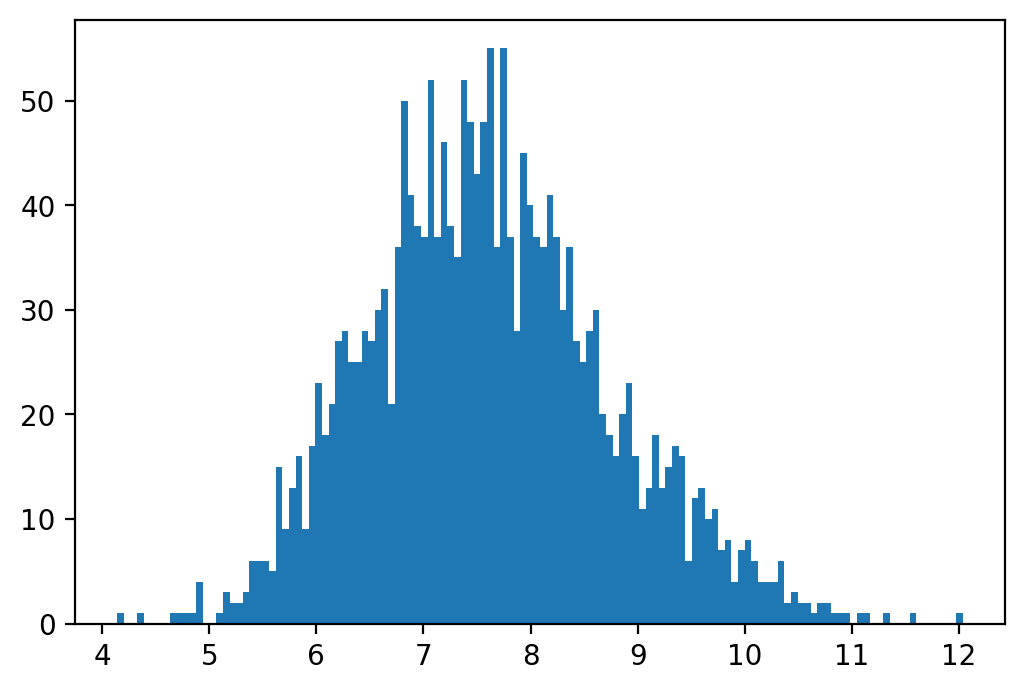

In [16]:
gamma_sampling=gamma_model.sampling(data=dict(alpha=get_alpha, beta = get_beta), iter=1000, seed=10521020)

params=gamma_sampling.extract()
gammaSamplingHist=plt.hist(params['y'], bins=128)

print("Mean value: "+str(np.mean(params['y'])))

# INV GAMMA PART

In [17]:
# create data for inv gamma
dict_with_gamma_inv={
    f"shape={shape1}_scale={scale1}":stats.invgamma.rvs(a=shape1,scale=scale1,size=size),
    f"shape={shape2}_scale={scale2}":stats.invgamma.rvs(a=shape2,scale=scale2,size=size),
    f"shape={shape3}_scale={scale3}":stats.invgamma.rvs(a=shape3,scale=scale3,size=size),
    f"shape={shape4}_scale={scale4}":stats.invgamma.rvs(a=shape4,scale=scale4,size=size)
}

# change dict to pandas' DataFrame
df=pd.DataFrame.from_dict(dict_with_gamma_inv)
df_melt = df.melt()

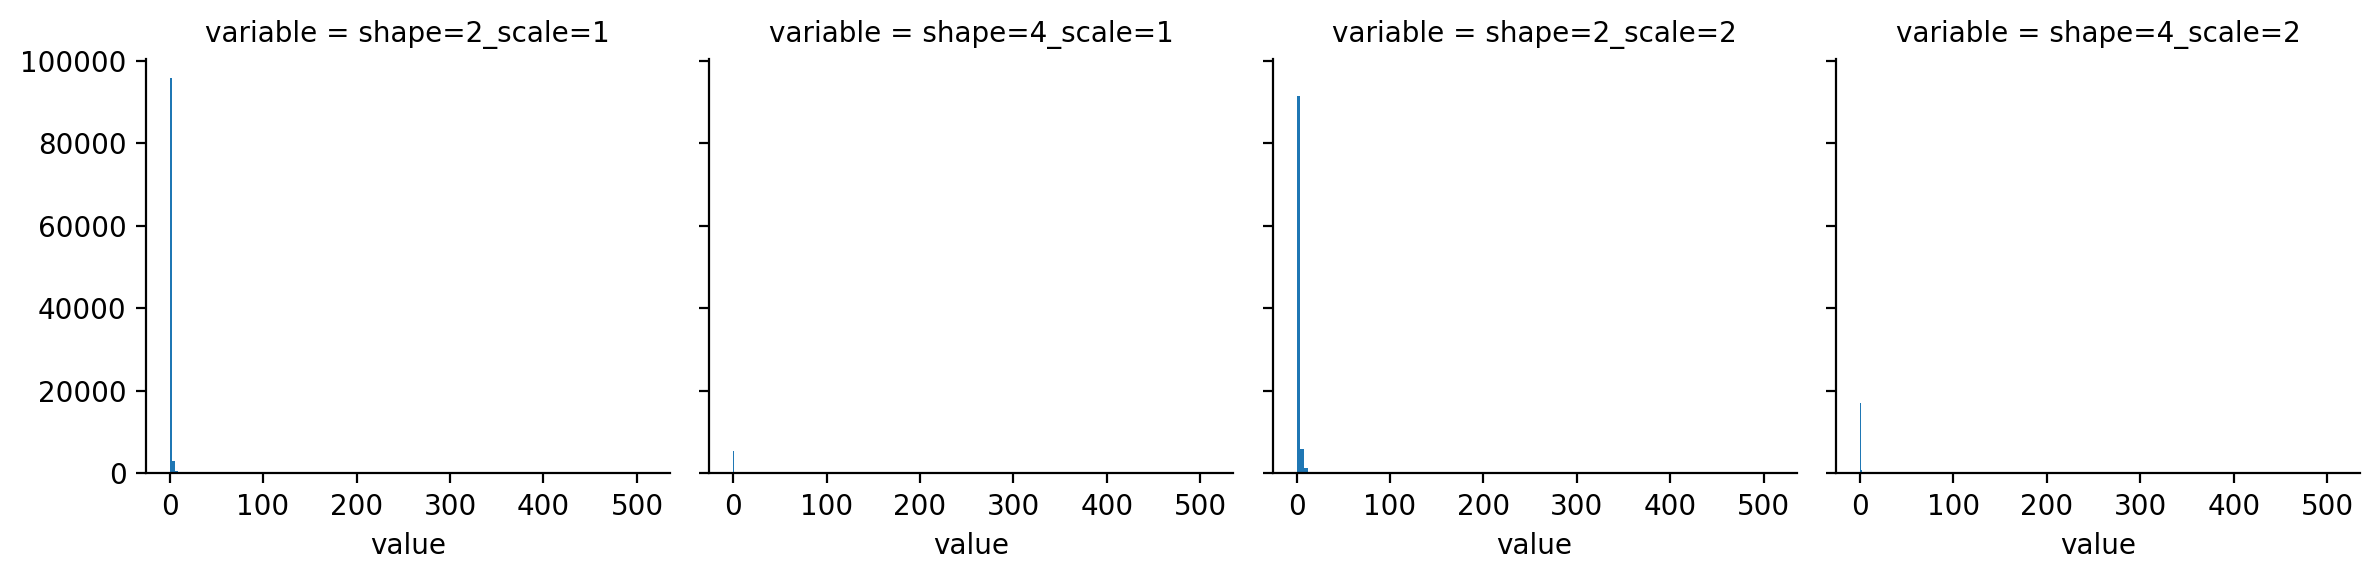

In [19]:
# plot the data
Graph=sns.FacetGrid(df_melt, col="variable", sharex=True, col_wrap=4).map(plt.hist, 'value', bins=128)

In [12]:
name_inv_prior_gamma = 'gamma_inv_prior.stan'

# show the model for inv gamma
with open(name_inv_prior_gamma, 'r') as file:
    print(file.read())
    
# compile it
model_gamma_inv_prior=stan_utility.compile_model(name_inv_prior_gamma)

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    //values between 5 and 10 with probabilty 98%
    deltas[1] = inv_gamma_cdf(theta[1], y[1], y[2]) -0.01; //only 1% will be <5
    deltas[2] = inv_gamma_cdf(theta[2], y[1], y[2]) -0.99; //olny 1% will be >10
    return deltas;
  }
}
data {
  vector<lower=0>[2] y_guess;
  vector<lower=0>[2] theta;
}
transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i, 1e-10, 1.2e-2, 1e6);
  print("alpha = ", y[1]);
  print("beta = ", y[2]);
}
generated quantities {
  real alpha = y[1];
  real beta = y[2];
}

Using cached StanModel


In [25]:
# We do have a compiled model so now we will use it. Starting from beta and alpha:
beta_inv=0.1
alpha_inv = 0.2

tuned_model_gamma_inv_prior= model_gamma_inv_prior.sampling(data = dict(y_guess=np.array([alpha_inv,beta_inv]), 
                                                                        theta=np.array([5, 10])),
                                                            algorithm="Fixed_param",
                                                            iter=1,
                                                            warmup=0,
                                                            chains=1)

get_alpha_inv = np.round(tuned_model_gamma_inv_prior.extract()['alpha'][0])
get_beta_inv = np.round(tuned_model_gamma_inv_prior.extract()['beta'][0])

print(f"Alpha: \t{get_alpha_inv}\nBeta: \t{get_beta_inv}")

Alpha: 	60.0
Beta: 	394.0


In [26]:
name_gamma_inv = 'gamma_inv.stan'

with open(name_gamma_inv, 'r') as file:
    print(file.read())
    
# compile it
gamma_inv_model = stan_utility.compile_model(name_gamma_inv)

data {
    real<lower=0> alpha;
    real<lower=0> beta;
}
parameters {
    real y;
}
model {
    y ~ inv_gamma(alpha, beta);
}
Using cached StanModel


Mean value: 6.6644637556028465


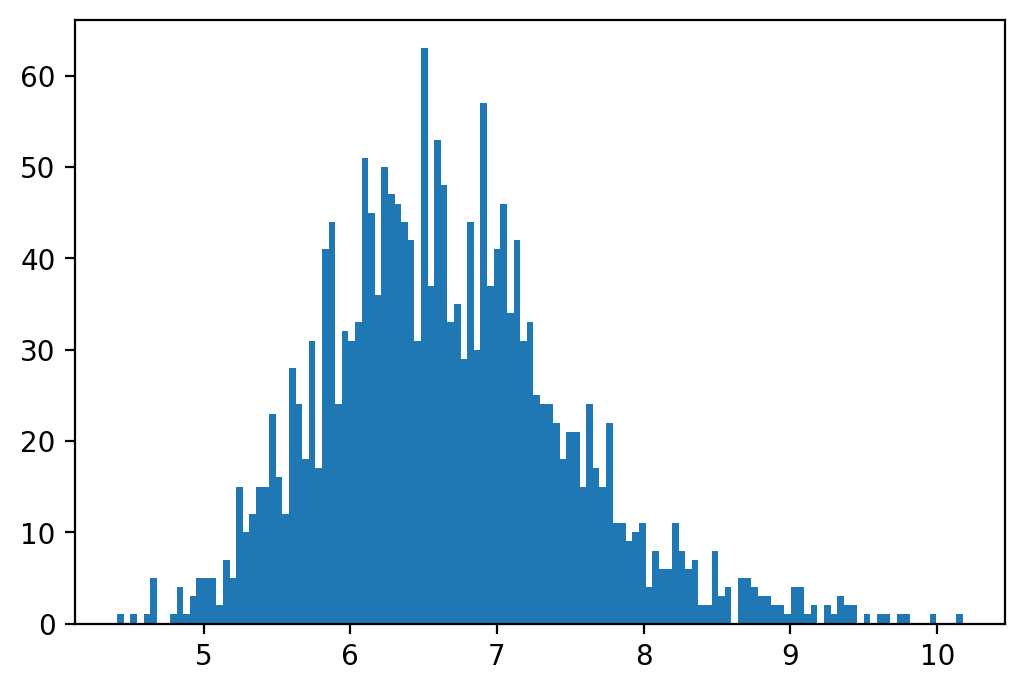

In [35]:
gamma_inv_sampling=gamma_inv_model.sampling(data=dict(alpha=get_alpha_inv, 
                                                      beta = get_beta_inv), 
                                            iter=1000, 
                                            seed=10521020)

inv_params=gamma_inv_sampling.extract()
gamma_inv_sampling=plt.hist(inv_params['y'], bins=128)
print("Mean value: "+str(np.mean(inv_params['y'])))

Mean value: 6.689257973085833


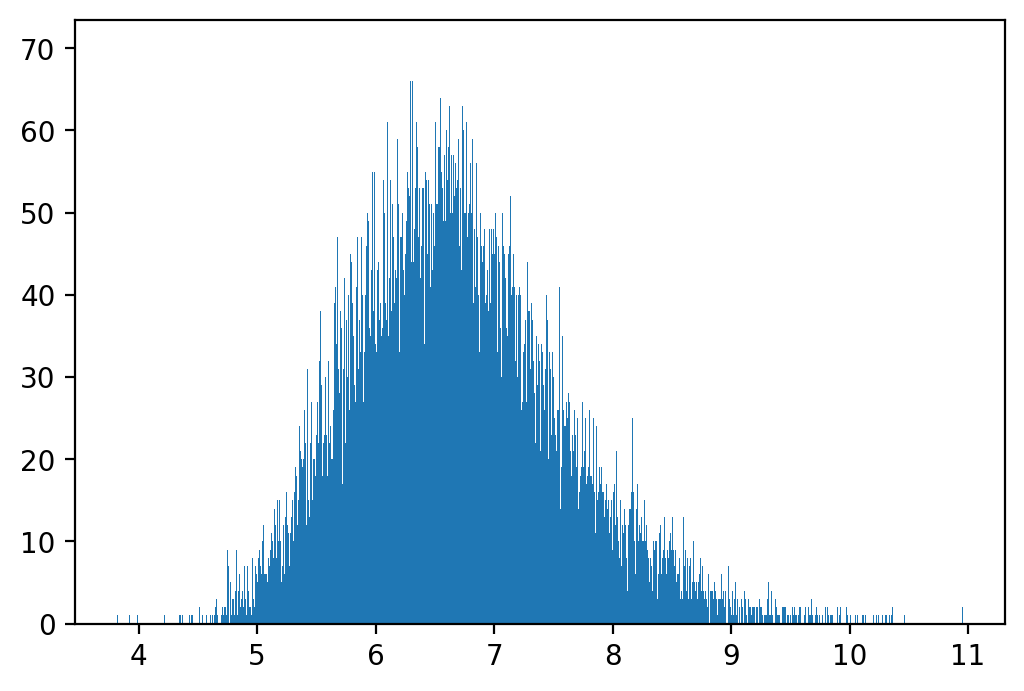

In [38]:
# more bins and more iterations
gamma_inv_sampling=gamma_inv_model.sampling(data=dict(alpha=get_alpha_inv, 
                                                      beta = get_beta_inv), 
                                            iter=10000, # for more than 100000 there is a warning 
                                            seed=10521020)

inv_params=gamma_inv_sampling.extract()
gamma_inv_sampling=plt.hist(inv_params['y'], bins=1280)
print("Mean value: "+str(np.mean(inv_params['y'])))